# 1.0 Import Data

Dataset: https://archive.ics.uci.edu/dataset/186/wine+quality

In [552]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [553]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
wine_quality = fetch_ucirepo(id=186)

# data (as pandas dataframes)
X_raw = wine_quality.data.features
y_raw = wine_quality.data.targets

# metadata
print(wine_quality.metadata)

# variable information
print(wine_quality.variables)


{'uci_id': 186, 'name': 'Wine Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/186/wine+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/186/data.csv', 'abstract': 'Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/).', 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 4898, 'num_features': 11, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['quality'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Wed Nov 15 2023', 'dataset_doi': '10.24432/C56S3T', 'creators': ['Paulo Cortez', 'A. Cerdeira', 'F. Almeida', 'T. Matos', 'J. Reis'], 'intro_paper': {'ID': 252, 'type': 'NATIVE', 'title': 'Modeling wine preferences

In [554]:
y_raw["binary_quality"] = y_raw["quality"].apply(lambda x: 0 if x < 6 else 1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [555]:
y_raw

,quality,binary_quality
0,5,0
1,5,0
2,5,0
3,6,1
4,5,0
...,...,...
6492,6,1
6493,5,0
6494,6,1
6495,7,1


In [556]:
full_data = pd.concat([X_raw, y_raw["binary_quality"]], axis=1)

In [488]:
full_data = pd.concat([X_raw, y_raw - 3], axis=1)

In [557]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         6497 non-null   float64
 1   volatile_acidity      6497 non-null   float64
 2   citric_acid           6497 non-null   float64
 3   residual_sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free_sulfur_dioxide   6497 non-null   float64
 6   total_sulfur_dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  binary_quality        6497 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 609.2 KB


In [558]:
# Check if there are duplicates
full_data.duplicated().sum()

1179

In [559]:
full_data.drop_duplicates(inplace=True)

In [560]:
full_data.shape

(5318, 12)

# 2.0 Dataset Preprocessing

We are splitting the dataset into 3 sets, including:

- Validation: 15% (model never seen it);
- Test: 15%;
- Train: 70%.

In [561]:
# Randomly take 15% of the dataset as validation set, seeding: 27
validation_data = full_data.sample(frac=0.15, random_state=27)
train_test_data = full_data.drop(validation_data.index)

In [563]:
X_val = validation_data.drop('binary_quality', axis=1)
y_val = validation_data['binary_quality']

In [565]:
# Take the dataset's quality column as y, the rest as X
y = train_test_data['binary_quality']
X = train_test_data.drop('binary_quality', axis=1)

print(f'Feature train_test shape: {X.shape}')
print(f'Label train_test shape: {y.shape}')

Feature train_test shape: (4520, 11)
Label train_test shape: (4520,)


In [566]:
from sklearn.model_selection import train_test_split
# Train test split of the data using train_test_split function, with a ratio of 8:2
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=27, test_size=0.3)

----------

Please start from here:

As coded above, X_val y_val are validation set. Please do not use it until the end when validate the model to check the accuracy.

For training, X_train, X_test, y_train, y_test are defined for model training.

Before next meeting on Saturday:

1. Zhanyang: ResNet
2. Dylan: Neural Networks, logistic regression
3. Eric: JTT
4. Reza: SVM

Everyone:

Look for libraries for
**Forgettability Score**
to finding instances that is unforgettable and forgettable.





#3.0 Modeling

In [567]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [568]:
X_train_tensor = torch.from_numpy(X_train.values).float()
y_train_tensor = torch.from_numpy(y_train.values)

In [569]:
y_train_tensor.unique()

tensor([0, 1])

In [570]:
class SmallModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SmallModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, num_classes)
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [571]:
#Can be ranked 0-10, but dataset only has 3-9

In [572]:
model = SmallModel(input_size=X_train.shape[1], num_classes=7)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [573]:
epochs = 20
correctness_history = np.zeros((len(X_train), epochs))

In [574]:
for epoch in np.arange(epochs):
    model.train()
    optimizer.zero_grad()
    
    outputs = model(X_train_tensor)
    print(outputs)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    # After each epoch, record correctness
    model.eval()
    with torch.no_grad():
        predictions = torch.argmax(outputs, dim=1)
        correct = (predictions == y_train_tensor).cpu().numpy()
        correctness_history[:, epoch] = correct

tensor([[  1.1154,   0.4349,  -2.2112,  ...,  -0.5105,   2.3395,  -1.3371],
        [ 10.1644,  -5.5173, -17.9899,  ..., -11.0629,  21.8829,  -0.6332],
        [ 13.6983,  -5.6987, -28.1178,  ..., -16.1189,  31.3511,   0.6012],
        ...,
        [  5.8340,  -2.1421, -12.3045,  ...,  -6.5614,  13.8912,  -0.4284],
        [  7.3983,  -3.8956, -14.5219,  ...,  -7.9201,  15.4142,  -0.6619],
        [  6.1773,  -3.1571, -11.7271,  ...,  -6.4482,  13.4251,  -1.1741]],
       grad_fn=<AddmmBackward0>)
tensor([[  1.2221,   0.5463,  -2.2773,  ...,  -0.5973,   2.1677,  -1.4120],
        [ 11.1206,  -4.6000, -18.6507,  ..., -11.8934,  20.6563,  -1.3823],
        [ 15.1661,  -4.3327, -29.1013,  ..., -17.3684,  29.6007,  -0.5879],
        ...,
        [  6.4524,  -1.5580, -12.7242,  ...,  -7.1031,  13.1169,  -0.9291],
        [  8.0957,  -3.2534, -14.9755,  ...,  -8.5142,  14.5195,  -1.2127],
        [  6.7523,  -2.6053, -12.1181,  ...,  -6.9509,  12.6711,  -1.6126]],
       grad_fn=<AddmmBackwa

In [575]:
forgetting_events = np.sum(
    (correctness_history[:, 1:] < correctness_history[:, :-1]), axis=1
)
forgetting_events

array([1, 0, 0, ..., 1, 0, 0])

In [576]:
from collections import defaultdict

In [577]:
class_indices = defaultdict(list)
for idx, label in enumerate(y_train):
    class_indices[label].append(idx)

# Calculate the number of examples to keep per class
reduction_factor = 0.7  # Keep 70% of data
num_examples_to_keep_per_class = {}
for label, indices in class_indices.items():
    num_examples = len(indices)
    num_to_keep = max(1, int(num_examples * reduction_factor))  # Ensure at least one example is kept
    num_examples_to_keep_per_class[label] = num_to_keep

# Select examples to keep per class
indices_to_keep = []
for label, indices in class_indices.items():
    # Get forgetting scores or EL2N scores for the current class
    class_scores = forgetting_events[indices]  # or el2n_scores[indices]
    # Rank indices within the class
    sorted_class_indices = [indices[i] for i in np.argsort(class_scores)]
    # Select top examples to keep
    indices_to_keep.extend(sorted_class_indices[-num_examples_to_keep_per_class[label]:])

# Create the reduced dataset
X_train_reduced = X_train.reset_index().loc[indices_to_keep].drop(columns="index")
y_train_reduced = y_train.reset_index().loc[indices_to_keep].drop(columns="index")

In [578]:
X_train_reduced.shape

(2214, 11)

In [579]:
X_train.shape

(3164, 11)

In [580]:
"""sorted_indices = np.argsort(forgetting_events)
num_examples_to_keep = int(len(X_train) * 0.7)
indices_to_keep = sorted_indices[num_examples_to_keep:]"""

'sorted_indices = np.argsort(forgetting_events)\nnum_examples_to_keep = int(len(X_train) * 0.7)\nindices_to_keep = sorted_indices[num_examples_to_keep:]'

In [581]:
"""X_train_reduced = X_train.reset_index().loc[indices_to_keep]
y_train_reduced = y_train.reset_index().loc[indices_to_keep]"""

'X_train_reduced = X_train.reset_index().loc[indices_to_keep]\ny_train_reduced = y_train.reset_index().loc[indices_to_keep]'

In [584]:
X_train_reduced_tensor = torch.from_numpy(X_train_reduced.values).float()
y_train_reduced_tensor = torch.from_numpy(y_train_reduced["binary_quality"].values)

In [585]:
y_train_reduced["binary_quality"].unique()

array([0, 1])

In [586]:
y.value_counts()

1    2832
0    1688
Name: binary_quality, dtype: int64

In [587]:
y_train.value_counts()

1    2011
0    1153
Name: binary_quality, dtype: int64

In [588]:
class LargerModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LargerModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 10)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 10)
        self.fc4 = nn.Linear(10, num_classes)
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc4(x)
        return x

In [589]:
full_data_model = LargerModel(X_train.shape[1], num_classes=7)

In [590]:
criterion = nn.CrossEntropyLoss()
full_data_optimizer = optim.Adam(full_data_model.parameters(), lr=0.001)

In [591]:
X_test_tensor = torch.from_numpy(X_test.values).float()
y_test_tensor = torch.from_numpy(y_test.values)

In [592]:
for epoch in range(100):
    full_data_model.train()
    full_data_optimizer.zero_grad()
    outputs = full_data_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    full_data_optimizer.step()

In [593]:
full_data_model.eval()
with torch.no_grad():
    outputs_test = full_data_model(X_test_tensor)
    predictions_test = torch.argmax(outputs_test, dim=1)
    accuracy = (predictions_test == y_test_tensor).float().mean().item()
    print(f'Accuracy on test set with reduced dataset: {accuracy:.4f}')

Accuracy on test set with reduced dataset: 0.5664


In [594]:
reduced_data_model = LargerModel(X_train.shape[1], num_classes=7)

In [595]:
reduced_data_optimizer = optim.Adam(reduced_data_model.parameters(), lr=0.01)

In [596]:
for epoch in range(100):
    reduced_data_model.train()
    reduced_data_optimizer.zero_grad()
    outputs = reduced_data_model(X_train_reduced_tensor)
    loss = criterion(outputs, y_train_reduced_tensor)
    loss.backward()
    reduced_data_optimizer.step()

In [597]:
reduced_data_model.eval()
with torch.no_grad():
    outputs_test = reduced_data_model(X_test_tensor)
    predictions_test = torch.argmax(outputs_test, dim=1)
    accuracy = (predictions_test == y_test_tensor).float().mean().item()
    print(f'Accuracy on test set with reduced dataset: {accuracy:.4f}')

Accuracy on test set with reduced dataset: 0.6453


In [598]:
X_train

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
962,6.6,0.57,0.02,2.10,0.115,6.0,16.0,0.99654,3.38,0.69,9.5
3730,7.1,0.22,0.32,16.90,0.056,49.0,158.0,0.99980,3.37,0.38,9.6
1624,7.0,0.25,0.32,9.00,0.046,56.0,245.0,0.99550,3.25,0.50,10.4
2968,7.4,0.64,0.47,14.15,0.168,42.0,185.0,0.99840,2.90,0.49,9.3
1224,12.6,0.39,0.49,2.50,0.080,8.0,20.0,0.99920,3.07,0.82,10.3
...,...,...,...,...,...,...,...,...,...,...,...
1400,7.9,0.69,0.21,2.10,0.080,33.0,141.0,0.99620,3.25,0.51,9.9
4078,6.6,0.24,0.30,13.00,0.052,18.0,143.0,0.99825,3.37,0.49,9.4
6097,6.8,0.20,0.25,6.20,0.052,22.0,106.0,0.99350,3.09,0.54,10.8
5602,6.8,0.14,0.35,1.50,0.047,40.0,117.0,0.99111,3.07,0.72,11.1


In [599]:
X_train.shape[0]

3164

In [600]:
# For SHAP, data needs to be in numpy arrays
X_train_original_np = X_train.to_numpy()
X_train_reduced_np = X_train_reduced.to_numpy()

In [ ]:
background_samples = 100 
X_background = X_train_original_np[np.random.choice(X_train.shape[0], background_samples, replace=False)]

In [602]:
import shap

# For the original model
explainer_original = shap.DeepExplainer(full_data_model, torch.tensor(X_background, dtype=torch.float32))

# For the reduced model
explainer_reduced = shap.DeepExplainer(reduced_data_model, torch.tensor(X_background, dtype=torch.float32))


In [603]:
X_train_original_np.shape[0]

3164

In [614]:
X_train.mean()

fixed_acidity             7.216071
volatile_acidity          0.344049
citric_acid               0.320307
residual_sugar            5.033407
chlorides                 0.057151
free_sulfur_dioxide      30.162295
total_sulfur_dioxide    114.205910
density                   0.994534
pH                        3.223995
sulphates                 0.535913
alcohol                  10.557666
dtype: float64

In [615]:
X_train_reduced.mean()

fixed_acidity             7.225136
volatile_acidity          0.343126
citric_acid               0.320655
residual_sugar            5.017660
chlorides                 0.057704
free_sulfur_dioxide      30.098916
total_sulfur_dioxide    113.851852
density                   0.994570
pH                        3.225312
sulphates                 0.537931
alcohol                  10.552559
dtype: float64

In [604]:
X_train_original_np

array([[ 6.6 ,  0.57,  0.02, ...,  3.38,  0.69,  9.5 ],
       [ 7.1 ,  0.22,  0.32, ...,  3.37,  0.38,  9.6 ],
       [ 7.  ,  0.25,  0.32, ...,  3.25,  0.5 , 10.4 ],
       ...,
       [ 6.8 ,  0.2 ,  0.25, ...,  3.09,  0.54, 10.8 ],
       [ 6.8 ,  0.14,  0.35, ...,  3.07,  0.72, 11.1 ],
       [ 6.5 ,  0.32,  0.45, ...,  3.2 ,  0.7 , 12.7 ]])

In [ ]:
# Choose a subset of data to explain
sample_indices = np.random.choice(X_train_reduced_np.shape[0], 500, replace=False)
X_sample_original = X_train_original_np[sample_indices]
X_sample_tensor_original = torch.tensor(X_sample_original, dtype=torch.float32)

X_sample_reduced = X_train_reduced_np[sample_indices]
X_sample_tensor_reduced = torch.tensor(X_sample_reduced, dtype=torch.float32)

# Compute SHAP values
shap_values_original = explainer_original.shap_values(X_sample_tensor_original)
shap_values_reduced = explainer_reduced.shap_values(X_sample_tensor_reduced)


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [606]:
mean_abs_shap_values_original = np.mean([np.abs(sv) for sv in shap_values_original], axis=0)
mean_abs_shap_values_original = np.mean(mean_abs_shap_values_original, axis=0)  # Average over samples

mean_abs_shap_values_reduced = np.mean([np.abs(sv) for sv in shap_values_reduced], axis=0)
mean_abs_shap_values_reduced = np.mean(mean_abs_shap_values_reduced, axis=0)  # Average over samples

In [607]:
import pandas as pd

# Original model feature importances
fi_original = pd.DataFrame({
    'Feature': X_train.columns,
    'SHAP Importance Original': mean_abs_shap_values_original
})

# Reduced model feature importances
fi_reduced = pd.DataFrame({
    'Feature': X_train.columns,
    'SHAP Importance Reduced': mean_abs_shap_values_reduced
})

In [608]:
fi_comparison = fi_original.merge(fi_reduced, on='Feature')

# Calculate the percentage change
fi_comparison['Percentage Change'] = (
    (fi_comparison['SHAP Importance Reduced'] - fi_comparison['SHAP Importance Original']) /
    fi_comparison['SHAP Importance Original']
) * 100

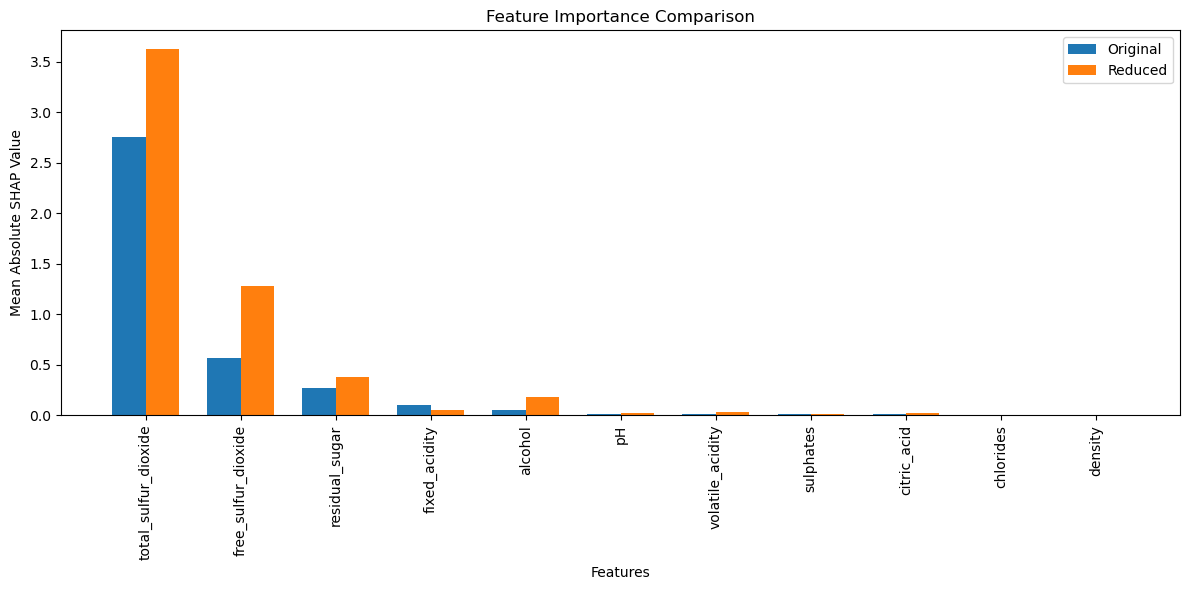

In [612]:
# Sort by original importance
fi_comparison_sorted = fi_comparison.sort_values('SHAP Importance Original', ascending=False)

# Plot
import matplotlib.pyplot as plt

x = np.arange(len(fi_comparison_sorted['Feature']))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, fi_comparison_sorted['SHAP Importance Original'], width, label='Original')
plt.bar(x + width/2, fi_comparison_sorted['SHAP Importance Reduced'], width, label='Reduced')
plt.title('Feature Importance Comparison')
plt.xlabel('Features')
plt.ylabel('Mean Absolute SHAP Value')
plt.xticks(x, fi_comparison_sorted['Feature'], rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


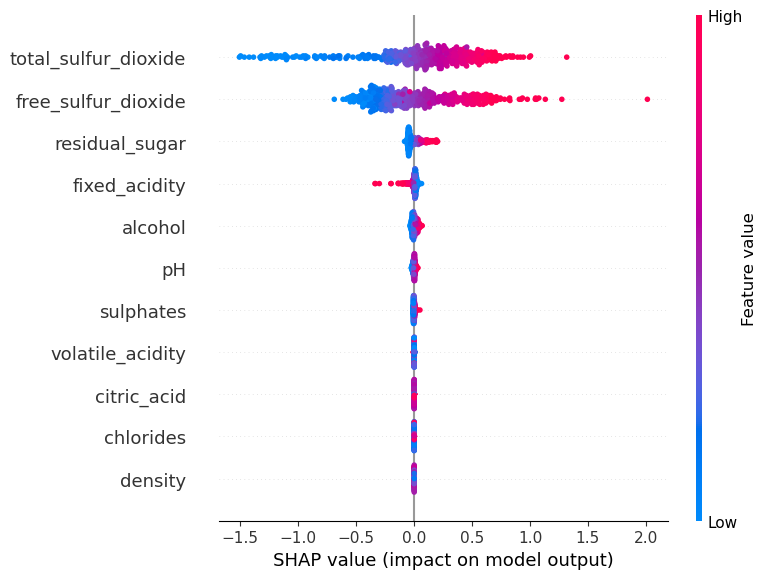

In [610]:
# For the original model
shap.summary_plot(np.array(shap_values_original).mean(axis=0), X_sample_original, feature_names=X_train.columns)

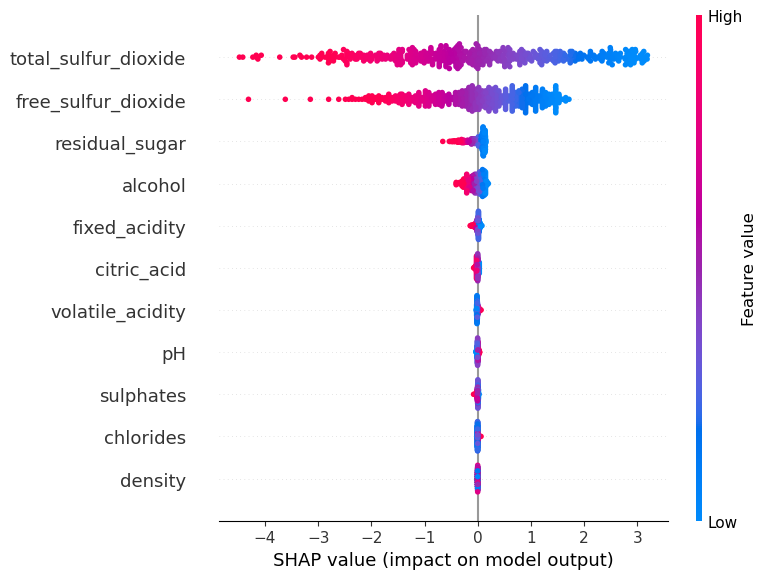

In [611]:
shap.summary_plot(np.array(shap_values_reduced).mean(axis=0), X_sample_reduced, feature_names=X_train.columns)

In [ ]:
import shap

# For the original model
explainer_original = shap.DeepExplainer(, torch.tensor(X_background, dtype=torch.float32))

# For the reduced model
explainer_reduced = shap.DeepExplainer(model_reduced, torch.tensor(X_background, dtype=torch.float32))


In [14]:
from sklearn import linear_model
model = linear_model.LogisticRegression(max_iter=1, random_state=10)

In [15]:
correct = np.zeros((len(X_train), 10), dtype=bool)

In [16]:
for epoch in range(10):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    correct[:, epoch] = y_pred == y_train

/Users/dylannewman/opt/anaconda3/envs/lign167/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/dylannewman/opt/anaconda3/envs/lign167/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://

In [36]:
forgetting_events = np.zeros(len(X_train), dtype=int)

for i in range(len(X_train)):
    correct_i = correct[i]
    forgetting_events[i] = np.sum((correct_i[:-1] == True) & (correct_i[1:] == False))

In [37]:
forgetting_events

array([0, 0, 0, ..., 0, 0, 0])

In [38]:
X_train

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol
0,6.6,0.57,0.02,2.10,0.115,6.0,16.0,0.99654,3.38,0.69,9.5
1,7.1,0.22,0.32,16.90,0.056,49.0,158.0,0.99980,3.37,0.38,9.6
2,7.0,0.25,0.32,9.00,0.046,56.0,245.0,0.99550,3.25,0.50,10.4
3,7.4,0.64,0.47,14.15,0.168,42.0,185.0,0.99840,2.90,0.49,9.3
4,12.6,0.39,0.49,2.50,0.080,8.0,20.0,0.99920,3.07,0.82,10.3
...,...,...,...,...,...,...,...,...,...,...,...
3159,7.9,0.69,0.21,2.10,0.080,33.0,141.0,0.99620,3.25,0.51,9.9
3160,6.6,0.24,0.30,13.00,0.052,18.0,143.0,0.99825,3.37,0.49,9.4
3161,6.8,0.20,0.25,6.20,0.052,22.0,106.0,0.99350,3.09,0.54,10.8
3162,6.8,0.14,0.35,1.50,0.047,40.0,117.0,0.99111,3.07,0.72,11.1


In [39]:
# Sort samples by forgetting scores
sorted_indices = np.argsort(forgetting_events)

# Define the fraction of data to keep
fraction = 0.8
n_keep = int(len(X_train) * fraction)
keep_indices = sorted_indices[:n_keep]

# Create the reduced training set
X_train_reduced = X_train.loc[keep_indices]
y_train_reduced = y_train.loc[keep_indices]


In [42]:
# Train on the full dataset
model_full = linear_model.LogisticRegression(max_iter=1000, random_state=10)
model_full.fit(X_train, y_train)

# Train on the reduced dataset
model_reduced = linear_model.LogisticRegression(max_iter=1000, random_state=10)
model_reduced.fit(X_train_reduced, y_train_reduced)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

LogisticRegression(max_iter=1000, random_state=10)

In [43]:
import shap

# Initialize SHAP explainers
explainer_full = shap.LinearExplainer(model_full, X_train)
explainer_reduced = shap.LinearExplainer(model_reduced, X_train_reduced)

# Compute SHAP values on the validation set
shap_values_full = explainer_full.shap_values(X_val)
shap_values_reduced = explainer_reduced.shap_values(X_val)

In [55]:
shap_values_full.shape

(798, 11, 7)

In [56]:
X_train.shape

(3164, 11)

In [60]:
# Sum SHAP values over classes
shap_values_full_sum = np.sum(shap_values_full, axis=2)  # Shape: (798, 11)
shap_values_reduced_sum = np.sum(shap_values_reduced, axis=2)  # Shape: (798, 11)

In [61]:
# Compute mean absolute SHAP values
mean_abs_shap_full = np.mean(np.abs(shap_values_full_sum), axis=0)
mean_abs_shap_reduced = np.mean(np.abs(shap_values_reduced_sum), axis=0)

# Feature names (assuming you have them)
feature_names = X.columns  # Replace with your actual feature names

# Create a DataFrame for easier comparison
import pandas as pd
shap_df = pd.DataFrame({
    'Feature': feature_names,
    'Full Model': mean_abs_shap_full,
    'Reduced Model': mean_abs_shap_reduced
})

# Display the comparison
print(shap_df)

                 Feature    Full Model  Reduced Model
0          fixed_acidity  2.784630e-13   7.326898e-13
1       volatile_acidity  9.187321e-14   1.308468e-14
2            citric_acid  5.084386e-14   1.432294e-13
3         residual_sugar  1.963697e-13   2.026338e-13
4              chlorides  6.357738e-15   6.879431e-15
5    free_sulfur_dioxide  2.364209e-13   1.747936e-12
6   total_sulfur_dioxide  2.776568e-12   2.966382e-12
7                density  2.125454e-15   8.623223e-16
8                     pH  2.114250e-13   3.984256e-13
9              sulphates  4.699062e-14   3.336260e-14
10               alcohol  1.425456e-12   1.346149e-12


In [70]:
model_full.score(X_val, y_val)

0.525062656641604

In [71]:
model_reduced.score(X_val, y_val)

0.5213032581453634

In [68]:
X_train["density"].mean()

0.9945339664981037

In [69]:
X_train_reduced["density"].mean()

0.9945307902015015

In [40]:
import shap
X100 = shap.utils.sample(X, 100)
explainer = shap.Explainer(model.predict, X100)
shap_values = explainer(X)

KeyboardInterrupt: 

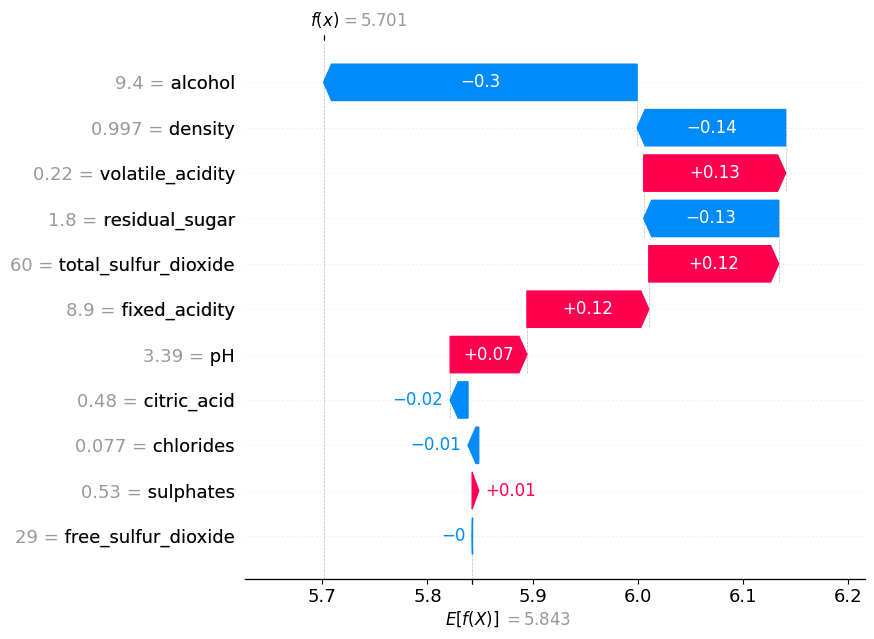

In [ ]:
shap.plots.waterfall(shap_values[20], max_display=14)

In [ ]:
y.iloc[20]

,20
quality,6
